In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, sin, cos, sqrt, atan2

In [4]:
# Load the amenities and restaurant data
amenities = pd.read_json('./data/amenities-vancouver.json.gz', lines=True)
chain_restaurants = pd.read_csv('./data/list_of_chain_restaurants.csv')
chain_restaurants['list'] = chain_restaurants

def in_list(example):
	if example in list(chain_restaurants['list']):
		return True
	else:
		return False
	
def sep_chain_nonchain(example):
	restaurant_list=example[(example['amenity']=='bbq')|(example['amenity']=='restaurant')|(example['amenity']=='fast_food')
	|(example['amenity']=='cafe')|(example['amenity']=='bar')|(example['amenity']=='juice_bar')|(example['amenity']=='food_court')]
	yes_chain=restaurant_list[restaurant_list['name'].apply(in_list)]
	no_chain=restaurant_list[~restaurant_list['name'].apply(in_list)]
	return yes_chain,no_chain
     
    
yes_chain, no_chain=sep_chain_nonchain(amenities)

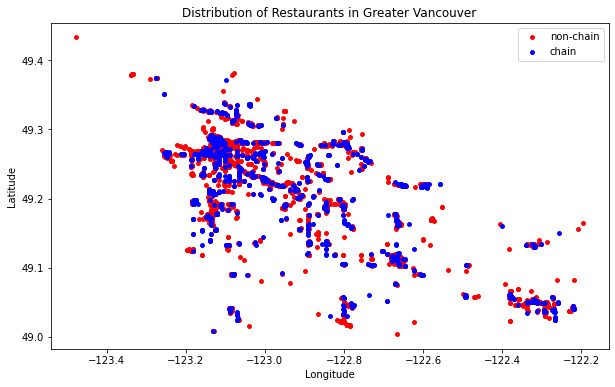

In [5]:
# Visualization 1: Distribution chart of restaurants in Greater Vancouver
plt.figure(figsize=(10,6))
plt.scatter(no_chain['lon'], no_chain['lat'], c="red", s=15)
plt.scatter(yes_chain['lon'], yes_chain['lat'], c="blue", s=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Restaurants in Greater Vancouver')
plt.legend(['non-chain', 'chain'])
# The following codes are adapted from https://stackoverflow.com/questions/49039581/matplotlib-savefig-will-not-overwrite-old-files .
strFile = "./results/Figure1.jpg"
if os.path.isfile(strFile):
   os.remove(strFile)   # Opt.: os.system("rm "+strFile)
plt.savefig(strFile)
plt.show()
     

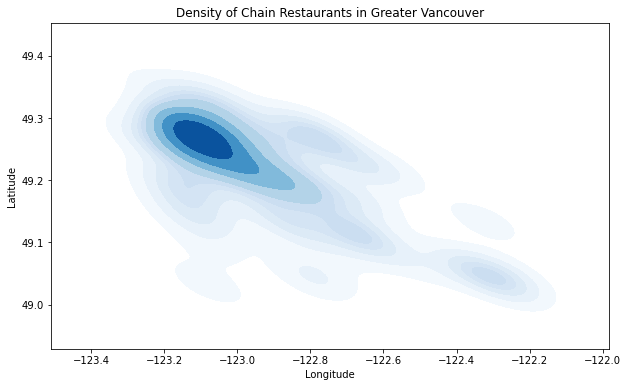

In [6]:
# Visualization 2: Density plot for chain and non-chain restaurants in Greater Vancouver
plt.figure(figsize=(10, 6))
sns.kdeplot(x=yes_chain['lon'], y=yes_chain['lat'], fill=True, cmap='Blues')
#sns.kdeplot(x=no_chain['lon'], y=no_chain['lat'], fill=True, cmap='Reds')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density of Chain Restaurants in Greater Vancouver')
# Saving the figure
strFile = "./results/Figure2.1.jpg"
if os.path.isfile(strFile):
    os.remove(strFile)   # Remove the file if it exists
plt.savefig(strFile)
plt.show()


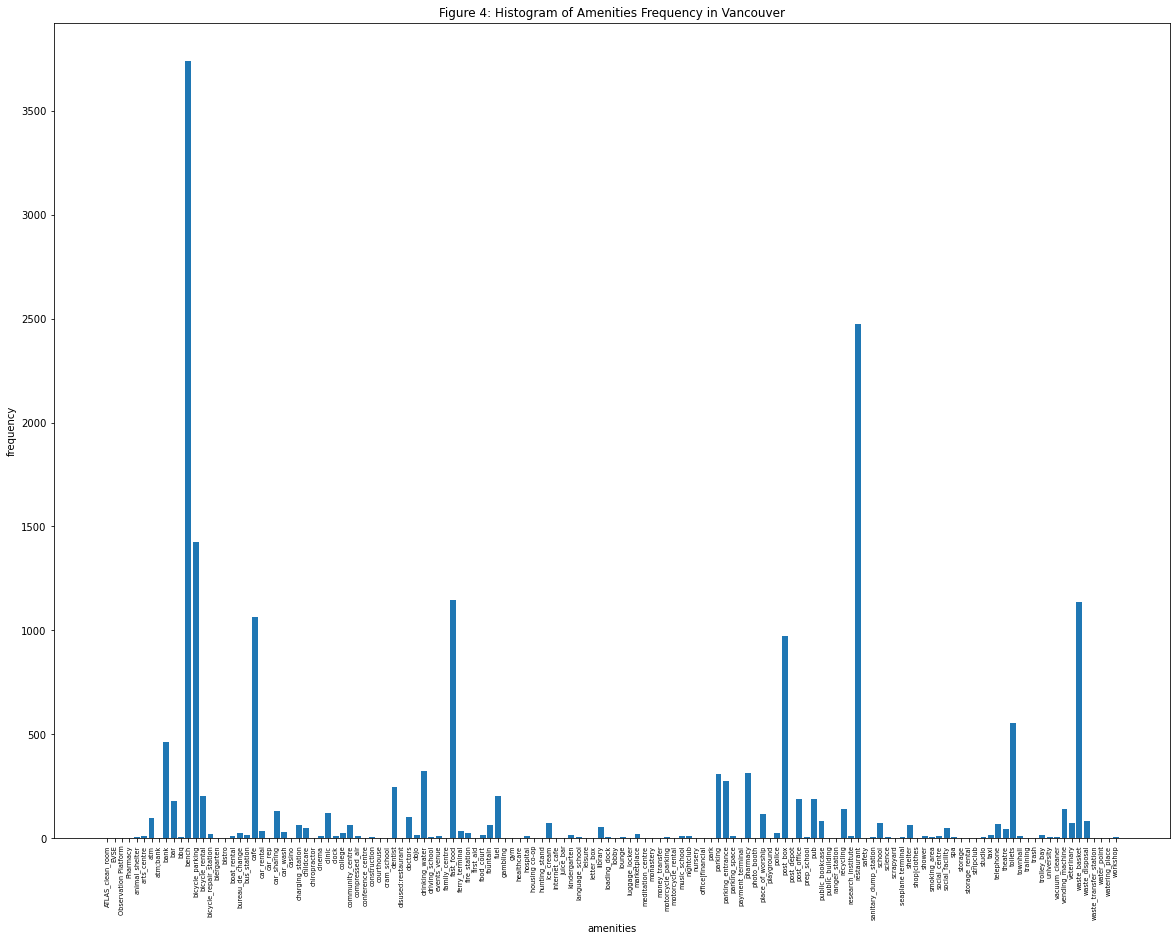

In [7]:
# Figure 3
summary=amenities.groupby('amenity').count()
summary=summary.drop(['timestamp','tags','lon','name'], axis=1)
summary=summary.rename(columns={"lat":"number"}).reset_index()
plt.figure(figsize=(20,15))
plt.xlabel('amenities')
plt.ylabel('frequency')
plt.title('Figure 4: Histogram of Amenities Frequency in Vancouver')
plt.bar(summary['amenity'],summary['number'])
plt.xticks(size=6.5,rotation='vertical')
# The following codes are adapted from https://stackoverflow.com/questions/49039581/matplotlib-savefig-will-not-overwrite-old-files .
strFile = "./results/Figure3.jpg"
if os.path.isfile(strFile):
   os.remove(strFile)   # Opt.: os.system("rm "+strFile)
plt.savefig(strFile)
plt.show()

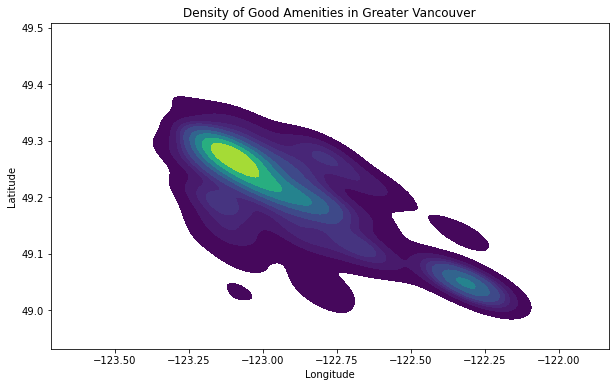

In [8]:
# Filter amenities to only include the specified ones
good_amenities = amenities[amenities['amenity'].isin(['atm', 'bus_station', 'clinic', 'fast_food', 'marketplace'])]

# Visualization 4: Density plot for selected amenities in Greater Vancouver
plt.figure(figsize=(10, 6))
sns.kdeplot(x=good_amenities['lon'], y=good_amenities['lat'], fill=True, cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density of Good Amenities in Greater Vancouver')
# Saving the figure
strFile = "./results/Figure4.jpg"
if os.path.isfile(strFile):
   os.remove(strFile)   # Remove the file if it exists
plt.savefig(strFile)
plt.show()


In [9]:
# Define good amenities
good_amenities_list = ['atm', 'bus_station', 'clinic', 'fast_food', 'marketplace']
amenities['is_good'] = amenities['amenity'].isin(good_amenities_list).astype(int)

# Calculate density for each amenity based on count in proximity
# Here, we simply count occurrences by location, you might want to refine this by geographic density calculation
amenities['density'] = amenities.groupby(['lat', 'lon'])['amenity'].transform('size')

# Divide amenities into good and others
good_amenities = amenities[amenities['is_good'] == 1]
other_amenities = amenities[amenities['is_good'] == 0]

# Hypothesis Testing with T-test
t_stat, p_value = stats.ttest_ind(good_amenities['density'], other_amenities['density'], equal_var=False)  # assuming variances are not equal
print(f"T-test result: statistic={t_stat}, p-value={p_value}")

# Regression Analysis
# Prepare the data
X = amenities[['lat', 'lon']]
y = amenities['density']

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients
coef_lat, coef_lon = model.coef_
intercept = model.intercept_


#print(f"Regression model: density = {intercept:.2f} + {coef_lat:.2f}*latitude + {coef_lon:.2f}*longitude")

# Assess the model
#print(f"Model R-squared: {model.score(X_test, y_test):.2f}")

T-test result: statistic=0.7938555961644236, p-value=0.4274048594357601


In [10]:

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Downtown Vancouver coordinates
downtown_lat, downtown_lon = 49.282730, -123.120735

# Calculate the distance of each amenity from downtown
amenities['distance'] = amenities.apply(lambda x: haversine(downtown_lon, downtown_lat, x['lon'], x['lat']), axis=1)

# Identify good amenities based on your criteria
good_amenities = amenities[amenities['amenity'].isin(['atm', 'bus_station', 'clinic', 'fast_food', 'marketplace'])]

# Group by distance bins and count number of good amenities in each bin
max_distance = good_amenities['distance'].max()
bins = pd.interval_range(start=0, end=max_distance, freq=1)  # 1 km bins
good_amenities['distance_bin'] = pd.cut(good_amenities['distance'], bins=bins)
density_by_bin = good_amenities.groupby('distance_bin').size()

# Perform a linear regression between bin mid-points and densities
bin_centers = [bin.mid for bin in density_by_bin.index]
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, density_by_bin.values)

print(f"Linear regression result: slope={slope}, intercept={intercept}, R-squared={r_value**2}, p-value={p_value}")

plt.scatter(bin_centers, density_by_bin.values, label='Density by Distance')
plt.plot(bin_centers, intercept + slope*np.array(bin_centers), 'r', label='Fit line')
plt.xlabel('Distance from Downtown (km)')
plt.ylabel('Density of Good Amenities')
plt.title('Density of Good Amenities vs. Distance from Downtown Vancouver')
plt.legend()
plt.show()

/tmp/ipykernel_307833/167131480.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_amenities['distance_bin'] = pd.cut(good_amenities['distance'], bins=bins)
/tmp/ipykernel_307833/167131480.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_by_bin = good_amenities.groupby('distance_bin').size()


NameError: name 'linregress' is not defined